In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import shapiro

In [39]:
price_demand_df = pd.read_csv('price_demand_data.csv')
price_demand_df

,price,demand
0,1.05,283
1,0.86,771
2,1.21,185
3,0.94,531
4,0.76,1002
...,...,...
94,1.13,321
95,0.78,970
96,1.04,387
97,1.02,831


#### Q1
Linear Regression on Price and Demand

In [40]:
lr = LinearRegression()
lr.fit(price_demand_df[['price']],price_demand_df.demand.values)
r2_score(price_demand_df.demand.values,lr.predict(price_demand_df[['price']]))

0.6214724117783329

#### Q2
Generate Demand data using residuals and p=1

In [41]:
resid = price_demand_df.demand.values - lr.predict(price_demand_df[['price']])

In [42]:
# Test for normality
shapiro(resid)

ShapiroResult(statistic=0.9835943579673767, pvalue=0.25649407505989075)

In [118]:
#port_return = np.random.normal(size = 99, loc = np.mean(resid), scale = np.std(resid))
demand_data = resid + (lr.intercept_ + [1]*lr.coef_)
demand_data[:5]

array([357.5116295 , 585.64624991, 478.34563336, 455.06325184,
       679.87499749])

#### Q3

#### Costs

In [48]:
#Rushed print cost
g = 0.75
c = .5
t = 0.15

#### Objective Function
Maximize (pD - qc - g(D-q) - t(q-d)) for given q based on last 100 days of demand and price data

#### Constraints
We create a new variable (h) which denotes the total profit for that day such that<br>
h <= pD - cq - t(q-D)<br>
h <= pD - cq - tq + tD<br>
(c+t)q + h <= pD+tD<br>

h <= pD - cq - g(D-q)<br>
h <= pD - cq - gD + gq<br>
(c-g)q + h <= pD - gD <br>

h >= -inf<br>
q >= 0<br>


#### Coding NewsVendor Problem

In [49]:
nd = price_demand_df.shape[0] # number of days of demand data
nd

99

In [50]:
# decision variables are (q, h1, h2, ..., h25)
obj = np.zeros(nd+1)
obj[1:] = 1.0/nd
lb = np.zeros(nd+1)
lb[1:] = -np.inf # quantity printed needs to be non-negative, but profit on a given day could possibly be negative
rhs = np.zeros(2*nd)
direction = np.array(['<']*(2*nd))

In [51]:
A = np.zeros((2*nd,nd+1))
for r in range(nd):
    A[2*r,[0,r+1]] = [c+t,1] # location 1 is q, location r+1 is this h
    rhs[2*r] = (1+t)*demand_data[r]
    A[2*r+1,[0,r+1]] = [c-g,1]
    rhs[2*r+1] = (1-g)*demand_data[r]

In [120]:
for r in range(1):
    print(A[r],direction[r],rhs[r])

[-9.44524325e+02 -2.50000000e-01  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

In [53]:
spMod = gp.Model()
spMod_x = spMod.addMVar(len(obj),lb=lb) # tell the model how many variables there are
# must define the variables before adding constraints because variables go into the constraints
spMod_con = spMod.addMConstrs(A, spMod_x, direction, rhs) # NAME THE CONSTRAINTS!!! so we can get information about them later!
spMod.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE) # add the objective to the model...we'll talk about the None and the 0

spMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
spMod.optimize()

In [54]:
spMod_x.x[0]

471.8653795908935

In [56]:
spMod.objval

231.4836666471413

#### Q4 - Price impacts Demand

#### Solving it using QP

In [99]:
lr = LinearRegression()
lr.fit(price_demand_df[['price']],price_demand_df.demand.values)

LinearRegression()

In [100]:
# obj func would be (p,q,h1,h2....h99)
Q = np.zeros((2+nd,2+nd))
Q[0,0] = lr.coef_
#Q

linear_obj = np.zeros(2+nd)
linear_obj[0] = lr.intercept_+np.mean(resid)
linear_obj[2:] = 1.0/nd
#linear_obj

lb = np.zeros(nd+2)
lb[2:] = -np.inf # quantity printed needs to be non-negative, but profit on a given day could possibly be negative

ub = np.zeros(nd+2)
ub[0:2] = np.inf

A.shape

A = np.zeros((2*nd,nd+2))
rhs = np.zeros(2*nd)
direction = ['<']*(2*nd)
for r in range(nd):
    A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
    rhs[2*r] = -g*(lr.intercept_+resid[r])
    A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
    rhs[2*r+1] = (t)*(lr.intercept_+resid[r])

<ipython-input-100-ada8a0c23341>:23: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-100-ada8a0c23341>:25: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]


In [101]:
#solving the optimization problem 
miqp_mod = gp.Model()
miqp_mod_x = miqp_mod.addMVar(nd+2, lb = lb)
miqp_mod_con = miqp_mod.addMConstrs(A, miqp_mod_x, direction, rhs)
miqp_mod.setMObjective(Q,linear_obj,0,sense=gp.GRB.MAXIMIZE)
miqp_mod.Params.OutputFlag = 0 
miqp_mod.optimize()

print(miqp_mod.ObjVal)

print(miqp_mod_x.x[0])

print(miqp_mod_x.x[1])

234.4249348783187
0.9536264966232614
535.2910012788706


##### Solving it using NLP

In [78]:
# decision variables are (q, h1, h2, ..., h25)
obj = np.zeros(nd+1)
obj[1:] = 1.0/nd
lb = np.zeros(nd+1)
lb[1:] = -np.inf # quantity printed needs to be non-negative, but profit on a given day could possibly be negative
rhs = np.zeros(2*nd)
direction = np.array(['<']*(2*nd))

In [79]:
A = np.zeros((2*nd,nd+1))
for r in range(nd):
    A[2*r,[0,r+1]] = [c+t,1] # location 1 is q, location r+1 is this h
    rhs[2*r] = (price_demand_df.iloc[r,0]+t)*price_demand_df.iloc[r,1]
    A[2*r+1,[0,r+1]] = [c-g,1]
    rhs[2*r+1] = (price_demand_df.iloc[r,0]-g)*price_demand_df.iloc[r,1]

In [121]:
for r in range(1):
    print(A[r],direction[r],rhs[r])

[-9.44524325e+02 -2.50000000e-01  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

In [81]:
spMod = gp.Model()
spMod_x = spMod.addMVar(len(obj),lb=lb) # tell the model how many variables there are
# must define the variables before adding constraints because variables go into the constraints
spMod_con = spMod.addMConstrs(A, spMod_x, direction, rhs) # NAME THE CONSTRAINTS!!! so we can get information about them later!
spMod.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE) # add the objective to the model...we'll talk about the None and the 0

spMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
spMod.optimize()


In [82]:
spMod_x.x[0]

357.99999999999994

In [85]:
spMod.objval

183.96808080808086

#### Bootstrapping

In [102]:
def bootstrap_df(df):
    price = []
    demand = []
    for i in range(len(price_demand_df)):
        p,d = price_demand_df.iloc[np.random.choice(price_demand_df.index),:]
        price.append(p)
        demand.append(d)
    
    return price,demand

In [103]:
price,demand = bootstrap_df(price_demand_df)

lr = LinearRegression()
lr.fit(np.array(price).reshape(-1,1),demand)

# obj func would be (p,q,h1,h2....h99)
Q = np.zeros((2+nd,2+nd))
Q[0,0] = lr.coef_
#Q

linear_obj = np.zeros(2+nd)
linear_obj[0] = lr.intercept_+np.mean(resid)
linear_obj[2:] = 1.0/nd
#linear_obj

lb = np.zeros(nd+2)
lb[2:] = -np.inf # quantity printed needs to be non-negative, but profit on a given day could possibly be negative

ub = np.zeros(nd+2)
ub[0:2] = np.inf

A.shape

A = np.zeros((2*nd,nd+2))
rhs = np.zeros(2*nd)
direction = ['<']*(2*nd)
for r in range(nd):
    A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
    rhs[2*r] = -g*(lr.intercept_+resid[r])
    A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
    rhs[2*r+1] = (t)*(lr.intercept_+resid[r])

#solving the optimization problem 
miqp_mod = gp.Model()
miqp_mod_x = miqp_mod.addMVar(nd+2, lb = lb)
miqp_mod_con = miqp_mod.addMConstrs(A, miqp_mod_x, direction, rhs)
miqp_mod.setMObjective(Q,linear_obj,0,sense=gp.GRB.MAXIMIZE)
miqp_mod.Params.OutputFlag = 0 
miqp_mod.optimize()

print(miqp_mod.ObjVal)

print(miqp_mod_x.x[0])

print(miqp_mod_x.x[1])

In [ ]:
nsim = 1000
optimal_price = []
optimal_quantity = []
for sim in range(nsim):
    price,demand = bootstrap_df(price_demand_df)

    lr = LinearRegression()
    lr.fit(np.array(price).reshape(-1,1),demand)

    # obj func would be (p,q,h1,h2....h99)
    Q = np.zeros((2+nd,2+nd))
    Q[0,0] = lr.coef_
    #Q

    linear_obj = np.zeros(2+nd)
    linear_obj[0] = lr.intercept_+np.mean(resid)
    linear_obj[2:] = 1.0/nd
    #linear_obj

    lb = np.zeros(nd+2)
    lb[2:] = -np.inf # quantity printed needs to be non-negative, but profit on a given day could possibly be negative

    ub = np.zeros(nd+2)
    ub[0:2] = np.inf

    A.shape

    A = np.zeros((2*nd,nd+2))
    rhs = np.zeros(2*nd)
    direction = ['<']*(2*nd)
    for r in range(nd):
        A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
        rhs[2*r] = -g*(lr.intercept_+resid[r])
        A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
        rhs[2*r+1] = (t)*(lr.intercept_+resid[r])

    #solving the optimization problem 
    miqp_mod = gp.Model()
    miqp_mod_x = miqp_mod.addMVar(nd+2, lb = lb)
    miqp_mod_con = miqp_mod.addMConstrs(A, miqp_mod_x, direction, rhs)
    miqp_mod.setMObjective(Q,linear_obj,0,sense=gp.GRB.MAXIMIZE)
    miqp_mod.Params.OutputFlag = 0 
    miqp_mod.optimize()

    print(miqp_mod.ObjVal)

    print(miqp_mod_x.x[0])

    print(miqp_mod_x.x[1])
    
    optimal_price.append(miqp_mod_x.x[0])
    optimal_quantity.append(miqp_mod_x.x[1])
   

(array([ 26.,  82., 151., 261., 237., 140.,  61.,  35.,   6.,   1.]),
 array([0.92042538, 0.92913895, 0.93785252, 0.9465661 , 0.95527967,
        0.96399324, 0.97270681, 0.98142038, 0.99013396, 0.99884753,
        1.0075611 ]),
 <BarContainer object of 10 artists>)

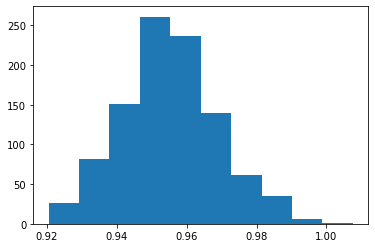

In [108]:
plt.hist(optimal_price)

(array([ 14.,  23.,  70., 177., 229., 250., 154.,  59.,  17.,   7.]),
 array([445.75362963, 463.79566436, 481.83769908, 499.8797338 ,
        517.92176852, 535.96380324, 554.00583796, 572.04787268,
        590.08990741, 608.13194213, 626.17397685]),
 <BarContainer object of 10 artists>)

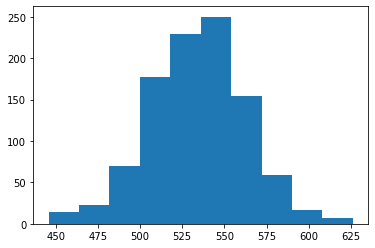

In [109]:
plt.hist(optimal_quantity)

In [110]:
import seaborn as sns

C:\Users\prakh\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


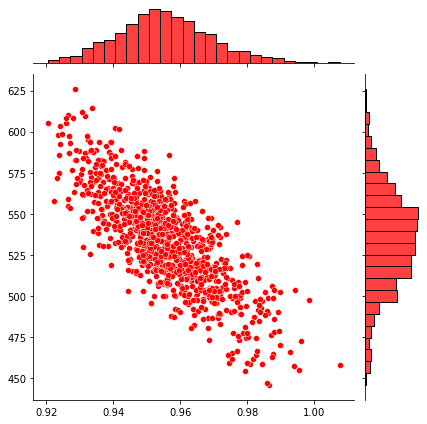

In [117]:
sns.jointplot(optimal_price,optimal_quantity,color='red',kind='scatter')